In [1]:
from sys import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
path.append(r'C:\Users\Izogie\Desktop\Folders\Projects\Python\KB Chat\src')
from modules.SourceManager import SourceManager

C:\Users\Izogie\AppData\Local\Temp\ipykernel_12220\985108771.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Original 8
## Questions to ask
- How many total unique links in 6 pages?
- How many on average are book refs, or wob refs?
- How bad are the outliers?
- What links do the articles have in common?

## Goals
- Answer questions
- Trim down links
- Option to produce a list of links that are only the articles downloaded

In [2]:
manager = SourceManager()
data = manager.load_json("./articles.jsonl")

In [3]:
df = pd.DataFrame.from_dict(data)
df

,title,links,sections
0,Kaladin,"[Durk, Rind, ref-book-sa1-23, Stormseat, ref-w...","[{'title': 'Kaladin', 'content': 'Kaladin, nic..."
1,Pits of Hathsin,"[Final Empire, ref-book-mb5-21, ref-book-mb1-4...","[{'title': 'Pits of Hathsin', 'content': 'The ..."
2,Allomancy,"[ref-wob-8025, cadmium, category: Metallic Art...","[{'title': 'Allomancy', 'content': 'Allomancy ..."
3,Cosmere,"[ref-wob-12276, Mistborn Era 4, ref-wob-3310, ...","[{'title': 'Cosmere', 'content': 'The cosmere ..."
4,Honor's Perpendicularity,"[Fused, Words of Radiance, Surgebinder, ref-bo...","[{'title': 'Honor's Perpendicularity', 'conten..."
5,Cephandrius,"[Hoid, Category: nominal redirects, Category: ...",None
6,Hoid,"[Tears of Edgli, Shinovar, ref-wob-3212, Rian,...","[{'title': 'Hoid', 'content': 'Hoid is a world..."


In [4]:
from functools import reduce
from operator import iconcat
# Unique links
df_links = df['links'].copy()
df_links_stats = df.copy()
df_links_stats['num_links'] = df_links.apply(lambda x: len(x))
num_links = df_links_stats['num_links'].sum()
print(f"Total links: {num_links}")
flattened_links = reduce(iconcat, df_links, [])
print(len(flattened_links))
set_flattened = set(flattened_links)
unique_sum = len(set_flattened)
print(f"Unique links: {unique_sum}")
print(f"{round(unique_sum/num_links*100,2)}% overlap")

Total links: 1722
1722
Unique links: 1467
85.19% overlap


In [5]:
# % wob and book refs
# total refs
def get_ref_stats(row):
    total_refs = 0
    wob_refs = 0
    book_refs = 0
    epi_refs = 0
    other_refs = []
    for i,link in enumerate(row['links']):
        if link.startswith("ref-"):
            total_refs += 1
            if link.startswith("ref-book"): book_refs += 1
            elif link.startswith("ref-wob"): wob_refs += 1
            elif link.startswith("ref-epi"): epi_refs += 1
            else: other_refs.append(link)
    row['num_total_refs'] = total_refs
    row['num_book_refs'] = book_refs
    row['num_wob_refs'] = wob_refs
    row['num_epi_refs'] = epi_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_total_refs'] = total_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_book_refs'] = book_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_wob_refs'] = wob_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_wob_refs'] = wob_refs
#     if total_refs > 0:
#         print(f"""{row['title']}
# Total refs: {total_refs}
# % wob: {(wob_refs/total_refs) * 100 if wob_refs > 0 else 0}
# % book: {(book_refs/total_refs) * 100 if book_refs > 0 else 0}
# """)
#     else:
#         print(f"{row['title']}\nTotal Refs: 0")
    return row

df_paras_stats = df.copy()
df_links_stats = df_links_stats.apply(lambda x: get_ref_stats(x), axis=1)
all_refs = df_links_stats['num_total_refs'].sum()
all_book_refs = df_links_stats['num_book_refs'].sum()
all_wob_refs = df_links_stats['num_wob_refs'].sum()
all_epi_refs = df_links_stats['num_epi_refs'].sum()

print(f"""Total Ref %
Total refs: {all_refs}
% wob: {round((all_wob_refs/all_refs) * 100,2)}
% book: {round((all_book_refs/all_refs) * 100,2)}
% epi: {round((all_epi_refs/all_refs) * 100,2)}
""")


Total Ref %
Total refs: 889
% wob: 49.94
% book: 43.87
% epi: 6.19



In [6]:
# Paragraphs
df_paras = df['sections'].copy()
df_paras_stats['num_paras'] = df_paras.apply(lambda x: len(x) if x is not None else 0)
avg_num_paras = df_paras_stats['num_paras'].sum()/len(df_paras)
print(f"Avg number of paras {round(avg_num_paras,2)}")

for idx, art in enumerate(df_paras):
    counter = 0
    if art is not None:
        for section in art:
            if section['content'] is not None:
                words = section['content'].split(" ")
                counter += len(words)
    df_paras_stats.loc[idx, "num_total_words"] = counter
total_words = df_paras_stats['num_total_words'].sum()
print(f"Avg number of words: {round(total_words/len(df_paras),1)}")

Avg number of paras 84.57
Avg number of words: 7431.9


In [7]:
df_paras_stats

,title,links,sections,num_paras,num_total_words
0,Kaladin,"[Durk, Rind, ref-book-sa1-23, Stormseat, ref-w...","[{'title': 'Kaladin', 'content': 'Kaladin, nic...",219,28006.0
1,Pits of Hathsin,"[Final Empire, ref-book-mb5-21, ref-book-mb1-4...","[{'title': 'Pits of Hathsin', 'content': 'The ...",7,540.0
2,Allomancy,"[ref-wob-8025, cadmium, category: Metallic Art...","[{'title': 'Allomancy', 'content': 'Allomancy ...",36,2248.0
3,Cosmere,"[ref-wob-12276, Mistborn Era 4, ref-wob-3310, ...","[{'title': 'Cosmere', 'content': 'The cosmere ...",121,8736.0
4,Honor's Perpendicularity,"[Fused, Words of Radiance, Surgebinder, ref-bo...","[{'title': 'Honor's Perpendicularity', 'conten...",6,379.0
5,Cephandrius,"[Hoid, Category: nominal redirects, Category: ...",None,0,0.0
6,Hoid,"[Tears of Edgli, Shinovar, ref-wob-3212, Rian,...","[{'title': 'Hoid', 'content': 'Hoid is a world...",203,12114.0


33


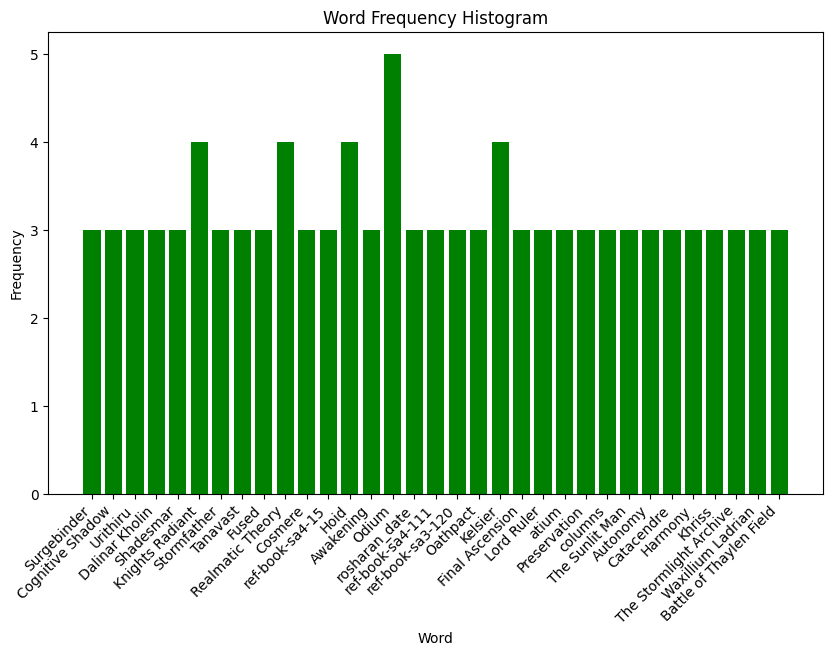

In [8]:
def plot_word_frequency_histogram(text):
    """Plots a histogram of word frequencies from a given text."""

    # Tokenize and normalize
    
    # Count frequencies
    title_counts = Counter(text)
    
    shared_titles = [(title,count) for title, count in title_counts.items() if count > 2]
    print(len(shared_titles))

    # Prepare data for plotting
    labels, values = zip(*shared_titles)

    # Create histogram
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.bar(labels, values, color='green')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Histogram')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
    plt.show()

plot_word_frequency_histogram(flattened_links)


In [9]:
title_counts = Counter(flattened_links)

shared_titles = [title for title, count in title_counts.items() if count == len(df_links)]

print("Titles shared across all lists:", shared_titles)

titles_over_once = {title:count for title, count in title_counts.items() if count > 1}
# print(shared_titles)
top_30 = Counter(dict(title_counts.most_common(30)))
print(f"Top 30 most common links by occurance:")
for key, val in top_30.items():
    print(f"{key}: {val}")

Titles shared across all lists: []
Top 30 most common links by occurance:
Odium: 5
Knights Radiant: 4
Realmatic Theory: 4
Hoid: 4
Kelsier: 4
Surgebinder: 3
Cognitive Shadow: 3
Urithiru: 3
Dalinar Kholin: 3
Shadesmar: 3
Stormfather: 3
Tanavast: 3
Fused: 3
Cosmere: 3
ref-book-sa4-15: 3
Awakening: 3
rosharan_date: 3
ref-book-sa4-111: 3
ref-book-sa3-120: 3
Oathpact: 3
Final Ascension: 3
Lord Ruler: 3
atium: 3
Preservation: 3
columns: 3
The Sunlit Man: 3
Autonomy: 3
Catacendre: 3
Harmony: 3
Khriss: 3


In [10]:
print(f"Links that show up more than once: {len(titles_over_once)} ({round(len(titles_over_once)/len(flattened_links)*100, 2)}%)")
# print(titles_over_once)

Links that show up more than once: 216 (12.54%)


# New articles

In [11]:
# Get top 12 related articles for PoC test
new_arts = [title for title in top_30.keys() if title not in df['title'].to_list() and not title.startswith("ref")][:20-len(df)]
print(new_arts)

['Odium', 'Knights Radiant', 'Realmatic Theory', 'Kelsier', 'Surgebinder', 'Cognitive Shadow', 'Urithiru', 'Dalinar Kholin', 'Shadesmar', 'Stormfather', 'Tanavast', 'Fused', 'Awakening']


In [24]:
old_arts = [
    "Kaladin",
    "Pits of Hathsin",
    "Allomancy",
    "Cosmere",
    "Honor's Perpendicularity",
    "Cephandrius",
    "Hoid"
]

In [28]:
manager = SourceManager()
manager.prep_data_graph(old_arts + new_arts)
# manager.save_json(manager.data)

MWClient Connected with coppermind.net
Processing Kaladin
Processing Pits of Hathsin
Processing Allomancy
Processing Cosmere
Processing Honor's Perpendicularity
Processing Cephandrius
Processing Hoid
Processing Odium
Processing Knights Radiant
Processing Realmatic Theory
Processing Kelsier
Processing Surgebinder
Processing Cognitive Shadow
Processing Urithiru
Processing Dalinar Kholin
Processing Shadesmar
Processing Stormfather
Processing Tanavast
Processing Fused
Processing Awakening
articles.jsonl saved


[{'title': 'Kaladin',
  'links': ['Urithiru',
   'Lamaril',
   'Court of Gods',
   'ref-book-sa2-77',
   'Fen Rnamdi',
   'knobweed',
   'Alethi',
   'ref-book-sa3-67',
   'Renarin Kholin',
   'ref-book-sa3-102',
   'Coreb',
   'ref-book-sa2-36',
   'Dragonsteel Prime',
   'Dallet',
   'Rillir Roshone',
   'Yunfah',
   'ref-book-sa4-38',
   'Oathpact',
   'ref-book-sa4-102',
   'ref-wob-4049',
   'ref-wob-10102',
   'ref-book-sa4-63',
   'darkeyes',
   'ref-book-sa4-80',
   'ref-book-sa2-i-6',
   'ref-book-sa1-63',
   'ref-book-sa3-61',
   'ref-book-sa1-44',
   'Luten',
   'Leyten',
   'Oathbringer (Shardblade)',
   'Sylphrena',
   'ref-book-sa1-69',
   'Szeth',
   'ref-book-sa4-37',
   'Helaran Davar',
   'ref-book-sa1-66',
   'ref-wob-11943',
   'Cord',
   'Realmatic Theory',
   'ref-book-sa3-82',
   'Battle of the Tower',
   'ref-book-sa4-103',
   'Vamah',
   'Dalinar Kholin',
   'ref-book-sa3-35',
   'ref-book-sa4-106',
   'Hoid',
   'Lyn',
   'Huio',
   'ref-book-sa3-31',
   'Orod

In [30]:
data = manager.load_json("./articles.jsonl")

In [31]:
df = pd.DataFrame.from_dict(data)
df

,title,links,sections
0,Kaladin,"[Urithiru, Lamaril, Court of Gods, ref-book-sa...","[{'title': 'Kaladin', 'content': 'Kaladin, nic..."
1,Pits of Hathsin,"[ref-book-mb1-32, ref-wob-1155, Scadrial, Cosm...","[{'title': 'Pits of Hathsin', 'content': 'The ..."
2,Allomancy,"[ref-wob-16102, ref-wob-361, ref-book-mb1-7, r...","[{'title': 'Allomancy', 'content': 'Allomancy ..."
3,Cosmere,"[Urithiru, ref-wob-8869, Threnodite system, re...","[{'title': 'Cosmere', 'content': 'The cosmere ..."
4,Honor's Perpendicularity,"[Taln, gloryspren, Stormfather, Words of Radia...","[{'title': 'Honor's Perpendicularity', 'conten..."
5,Cephandrius,"[Category: nominal redirects, Hoid, Category: ...",None
6,Hoid,"[Urithiru, ref-book-tress-13, ref-wob-5760, Sh...","[{'title': 'Hoid', 'content': 'Hoid is a world..."
7,Odium,"[Urithiru, Thaidakar, True Desolation, Dor, re...","[{'title': 'Odium', 'content': '<disable-googl..."
8,Knights Radiant,"[Urithiru, Cohesion, Wyndle, ref-book-sa2-84, ...","[{'title': 'Knights Radiant', 'content': 'The ..."
9,Realmatic Theory,"[ref-wob-1823, Elantrian, True Desolation, ref...","[{'title': 'Realmatic Theory', 'content': 'Rea..."


In [33]:
from functools import reduce
from operator import iconcat
# Unique links
df_links = df['links'].copy()
df_links_stats = df.copy()
df_links_stats['num_links'] = df_links.apply(lambda x: len(x))
num_links = df_links_stats['num_links'].sum()
print(f"Total links: {num_links}")
flattened_links = reduce(iconcat, df_links, [])
print(len(flattened_links))
set_flattened = set(flattened_links)
unique_sum = len(set_flattened)
print(f"Unique links: {unique_sum}")
print(f"{round(unique_sum/num_links*100,2)}% unique")

Total links: 3580
3580
Unique links: 2295
64.11% unique


In [34]:
# % wob and book refs
# total refs
def get_ref_stats(row):
    total_refs = 0
    wob_refs = 0
    book_refs = 0
    epi_refs = 0
    other_refs = []
    for i,link in enumerate(row['links']):
        if link.startswith("ref-"):
            total_refs += 1
            if link.startswith("ref-book"): book_refs += 1
            elif link.startswith("ref-wob"): wob_refs += 1
            elif link.startswith("ref-epi"): epi_refs += 1
            else: other_refs.append(link)
    row['num_total_refs'] = total_refs
    row['num_book_refs'] = book_refs
    row['num_wob_refs'] = wob_refs
    row['num_epi_refs'] = epi_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_total_refs'] = total_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_book_refs'] = book_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_wob_refs'] = wob_refs
    # df_paras_stats.loc[df_paras_stats.loc[:,'title'] == row['title'], 'num_wob_refs'] = wob_refs
#     if total_refs > 0:
#         print(f"""{row['title']}
# Total refs: {total_refs}
# % wob: {(wob_refs/total_refs) * 100 if wob_refs > 0 else 0}
# % book: {(book_refs/total_refs) * 100 if book_refs > 0 else 0}
# """)
#     else:
#         print(f"{row['title']}\nTotal Refs: 0")
    return row

df_paras_stats = df.copy()
df_links_stats = df_links_stats.apply(lambda x: get_ref_stats(x), axis=1)
all_refs = df_links_stats['num_total_refs'].sum()
all_book_refs = df_links_stats['num_book_refs'].sum()
all_wob_refs = df_links_stats['num_wob_refs'].sum()
all_epi_refs = df_links_stats['num_epi_refs'].sum()

print(f"""Total Ref %
Total refs: {all_refs}
% wob: {round((all_wob_refs/all_refs) * 100,2)}
% book: {round((all_book_refs/all_refs) * 100,2)}
% epi: {round((all_epi_refs/all_refs) * 100,2)}
""")


Total Ref %
Total refs: 1669
% wob: 44.1
% book: 51.17
% epi: 4.73



In [35]:
# Paragraphs
df_paras = df['sections'].copy()
df_paras_stats['num_paras'] = df_paras.apply(lambda x: len(x) if x is not None else 0)
avg_num_paras = df_paras_stats['num_paras'].sum()/len(df_paras)
print(f"Avg number of paras {round(avg_num_paras,2)}")

for idx, art in enumerate(df_paras):
    counter = 0
    if art is not None:
        for section in art:
            if section['content'] is not None:
                words = section['content'].split(" ")
                counter += len(words)
    df_paras_stats.loc[idx, "num_total_words"] = counter
total_words = df_paras_stats['num_total_words'].sum()
print(f"Avg number of words: {round(total_words/len(df_paras),1)}")

Avg number of paras 52.4
Avg number of words: 3944.8


In [36]:
df_paras_stats

,title,links,sections,num_paras,num_total_words
0,Kaladin,"[Urithiru, Lamaril, Court of Gods, ref-book-sa...","[{'title': 'Kaladin', 'content': 'Kaladin, nic...",219,28006.0
1,Pits of Hathsin,"[ref-book-mb1-32, ref-wob-1155, Scadrial, Cosm...","[{'title': 'Pits of Hathsin', 'content': 'The ...",7,540.0
2,Allomancy,"[ref-wob-16102, ref-wob-361, ref-book-mb1-7, r...","[{'title': 'Allomancy', 'content': 'Allomancy ...",36,2248.0
3,Cosmere,"[Urithiru, ref-wob-8869, Threnodite system, re...","[{'title': 'Cosmere', 'content': 'The cosmere ...",121,8736.0
4,Honor's Perpendicularity,"[Taln, gloryspren, Stormfather, Words of Radia...","[{'title': 'Honor's Perpendicularity', 'conten...",6,379.0
5,Cephandrius,"[Category: nominal redirects, Hoid, Category: ...",None,0,0.0
6,Hoid,"[Urithiru, ref-book-tress-13, ref-wob-5760, Sh...","[{'title': 'Hoid', 'content': 'Hoid is a world...",203,12114.0
7,Odium,"[Urithiru, Thaidakar, True Desolation, Dor, re...","[{'title': 'Odium', 'content': '<disable-googl...",55,3314.0
8,Knights Radiant,"[Urithiru, Cohesion, Wyndle, ref-book-sa2-84, ...","[{'title': 'Knights Radiant', 'content': 'The ...",39,1787.0
9,Realmatic Theory,"[ref-wob-1823, Elantrian, True Desolation, ref...","[{'title': 'Realmatic Theory', 'content': 'Rea...",25,2375.0


43


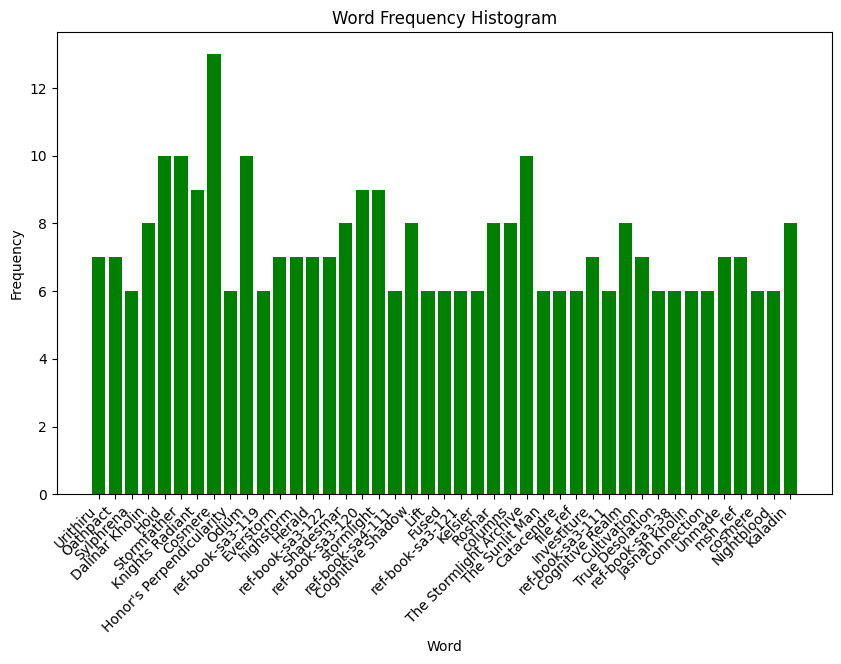

In [44]:
def plot_word_frequency_histogram(text):
    """Plots a histogram of word frequencies from a given text."""

    # Tokenize and normalize
    
    # Count frequencies
    title_counts = Counter(text)
    
    shared_titles = [(title,count) for title, count in title_counts.items() if count > 5]
    print(len(shared_titles))

    # Prepare data for plotting
    labels, values = zip(*shared_titles)

    # Create histogram
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.bar(labels, values, color='green')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Histogram')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
    plt.show()

plot_word_frequency_histogram(flattened_links)


In [45]:
title_counts = Counter(flattened_links)

shared_titles = [title for title, count in title_counts.items() if count == len(df_links)]

print("Titles shared across all lists:", shared_titles)

# print(shared_titles)
top_30 = Counter(dict(title_counts.most_common(30)))
print(f"Top 30 most common links by occurance:")
for key, val in top_30.items():
    print(f"{key}: {val}")

Titles shared across all lists: []
Top 30 most common links by occurance:
Cosmere: 13
Hoid: 10
Stormfather: 10
Odium: 10
The Stormlight Archive: 10
Knights Radiant: 9
ref-book-sa3-120: 9
stormlight: 9
Dalinar Kholin: 8
Shadesmar: 8
Cognitive Shadow: 8
Roshar: 8
columns: 8
Cognitive Realm: 8
Kaladin: 8
Urithiru: 7
Oathpact: 7
Everstorm: 7
highstorm: 7
Herald: 7
ref-book-sa3-122: 7
Investiture: 7
Cultivation: 7
Unmade: 7
msh_ref: 7
Sylphrena: 6
Honor's Perpendicularity: 6
ref-book-sa3-119: 6
ref-book-sa4-111: 6
Lift: 6


In [47]:
titles_over_once = {title:count for title, count in title_counts.items() if count > 1}
print(f"Links that show up more than once: {len(titles_over_once)} ({round(len(titles_over_once)/len(flattened_links)*100, 2)}%)")
# print(titles_over_once)

Links that show up more than once: 669 (18.69%)
